# House Prices Prediction Notebook

![Image](house_img.jpg)

In this notebook, a dataset taken from Kaggle competition will be analyzed and a forecasting model will be created to predict House Sale Prices.

The competition can be found on this link: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

---

## Importing Libraries

In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer
 
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder

import math
# Setting the option to show all the df columns
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV

## Reading The Dataframe

In [31]:
# Reading the train df
train_df = pd.read_csv('../data/train.csv')

# Reading the test df
test_df = pd.read_csv('../data/test.csv')

In [32]:
# Showing top 5 rows of the Train df

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [33]:
print('The train df contains {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))

The train df contains 1460 rows and 81 columns


In [34]:
print('The test df contains {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

The test df contains 1459 rows and 80 columns


The train df will be used to train the model, the test df is given without 'SalePrice' of the houses and it is used to submit in the competition. Based on the results, the score is calculated from the competition.

## The distribution of "SalePrice" values

In [35]:
# Setting 'darkgrid' plot style for better visualizations

sns.set_style('darkgrid')

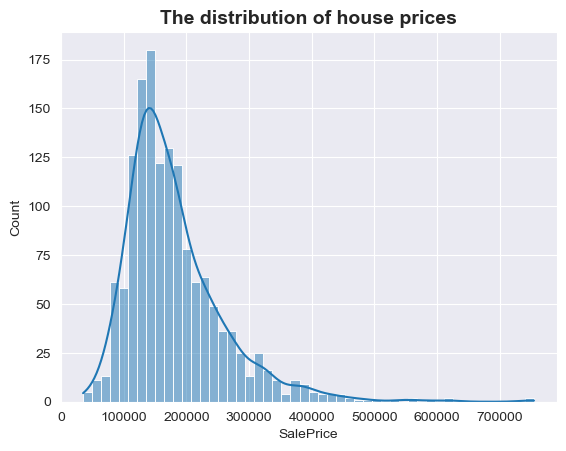

In [36]:
# Plotting the 'SalePrice' column distribution.

sns.histplot(data=train_df['SalePrice'], bins=50, kde=True)

plt.title('The distribution of house prices', fontsize=14, fontweight = 'bold')
plt.show()

## Checking if we have all columns in two dataframes

In [37]:
#features present in train data that are not present in test data

feature_train_not_test = [col for col in train_df.columns 
                          if col not in test_df.columns 
                          and col != 'SalePrice']

print("The number of features that are present in train but not test data is: ", len(feature_train_not_test))

The number of features that are present in train but not test data is:  0


In [38]:
#features present in test data that are not present in train data

feature_test_not_train = [col for col in test_df.columns if col not in train_df.columns]

print("The number of features that are present in test but not train data is: ", len(feature_test_not_train))

The number of features that are present in test but not train data is:  0


From the above results, we can understand that in both given datasets (train and test) we have the same features (same columns)!

## Data Cleaning

### Checking null values of the train df

In [39]:
# Checking columns with null values in Train DF

# Calculating the number of null values in train df
nulls_train = train_df.isna().sum()[train_df.isna().sum() > 0].reset_index().rename(columns={0:'#_of_nulls'})

# Calculating the perfentage of null values in train df
nulls_perc_train = ((train_df.isna().sum()[train_df.isna().sum() > 0] / train_df.shape[0]) * 100).reset_index().rename(columns={0:'%_of_nulls'})

# Creating the df of nulls
train_nulls = nulls_train.merge(nulls_perc_train, how='left', left_on = ['index'], right_on = ['index']).set_index('index')
train_nulls

,#_of_nulls,%_of_nulls
index,,
LotFrontage,259,17.739726
Alley,1369,93.767123
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
BsmtQual,37,2.534247
BsmtCond,37,2.534247
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtFinType2,38,2.602740


### Checking null values of the test df

In [40]:
# Checking columns with null values in Test DF

# Calculating the number of null values in Test df
nulls_test = test_df.isna().sum()[test_df.isna().sum() > 0].reset_index().rename(columns={0:'#_of_nulls'})

# Calculating the perfentage of null values in Test df
nulls_perc_test = ((test_df.isna().sum()[test_df.isna().sum() > 0] / test_df.shape[0]) * 100).reset_index().rename(columns={0:'%_of_nulls'})

# Creating the df of nulls
test_nulls = nulls_test.merge(nulls_perc_test, how='left', left_on = ['index'], right_on = ['index']).set_index('index')
test_nulls

,#_of_nulls,%_of_nulls
index,,
MSZoning,4,0.274160
LotFrontage,227,15.558602
Alley,1352,92.666210
Utilities,2,0.137080
Exterior1st,1,0.068540
Exterior2nd,1,0.068540
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
BsmtQual,44,3.015764


As it is shown above, there are lots of null values in these datasets, we will clean and fill them before creating the model.

All the data will be cleaned based on column types and also by columns definitions, which can be found on <code>data_description.txt</code>, in **data** directory!

In [41]:
# Creating functions to fill null values 
# Based on column definition, null values will be filled diferentely

# Function for filling with mean
def fill_mean(df, column):
    """
    This function fills null values of a specific column 
    with the average value of that column
    """
    df[column].fillna(df[column].mean(), inplace=True)
    
# Function for filling with mode
def fill_mode(df, column):
    """
    This function fills null values of a specific column 
    with the mode value of that column
    """
    df[column].fillna(df[column].mode()[0], inplace=True)
    
# Function for filling with none
def fill_none(df, column):
    """
    This function fills null values of a specific column 
    with 'None'
    """
    df[column].fillna('None', inplace=True)
    
# Function for filling with zero
def fill_zero(df, column):
    """
    This function fills
    null values of a specific column 
    with zero
    """
    df[column].fillna(0.0, inplace=True)

### Filling null values of Train df

In [42]:
# Distinguishing columns to fill by different methods

train_fill_with_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
                        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'FireplaceQu', 'GarageType',
                       'GarageFinish', 'GarageQual', 'GarageCond',
                       'PoolQC', 'Fence', 'MiscFeature']

train_fill_with_mean = ['LotFrontage']

train_fill_with_zero = ['MasVnrArea']

train_fill_with_mode = ['Electrical']

# GarageYrBlt will not be filled since houses that do not have garage, their built year is unknown
# Also GarageYrBlt will not be used to train the model

In [43]:
# Filling null values of targeted columns with none values
for i in train_fill_with_none:
    fill_none(train_df, i)
    
# Filling null values of targeted columns with mean values
for i in train_fill_with_mean:
    fill_mean(train_df, i)
    
# Filling null values of targeted columns with zero values
for i in train_fill_with_zero:
    fill_zero(train_df, i)
    
# Filling null values of targeted columns with mode values
for i in train_fill_with_mode:
    fill_mode(train_df, i)

In [44]:
train_df.drop(['Id', 'GarageYrBlt'],axis=1, inplace=True)

### Filling null values of Test df

In [45]:
# Distinguishing columns to fill by different methods

test_fill_with_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
                        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'FireplaceQu', 'GarageType',
                       'GarageFinish', 'GarageQual', 'GarageCond',
                       'PoolQC', 'Fence', 'MiscFeature']

test_fill_with_mean = ['LotFrontage']

test_fill_with_zero = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2', 
                       'BsmtUnfSF','TotalBsmtSF','BsmtFullBath',
                      'BsmtHalfBath','GarageCars','GarageArea']

test_fill_with_mode = ['MSZoning','Utilities','Exterior1st','Exterior2nd',
                       'KitchenQual', 'Functional', 'SaleType']

# GarageYrBlt will not be filled since houses that do not have garage, their built year is unknown
# Also GarageYrBlt will not be used to train the model

In [46]:
# Filling null values of targeted columns with none values
for i in test_fill_with_none:
    fill_none(test_df, i)
    
# Filling null values of targeted columns with mean values
for i in test_fill_with_mean:
    fill_mean(test_df, i)
    
# Filling null values of targeted columns with zero values
for i in test_fill_with_zero:
    fill_zero(test_df, i)
    
# Filling null values of targeted columns with mode values
for i in test_fill_with_mode:
    fill_mode(test_df, i)

In [47]:
test_df.drop(['Id', 'GarageYrBlt'],axis=1, inplace=True)

## Data Exploration & Preprocessing

### Boxplot of numerical features

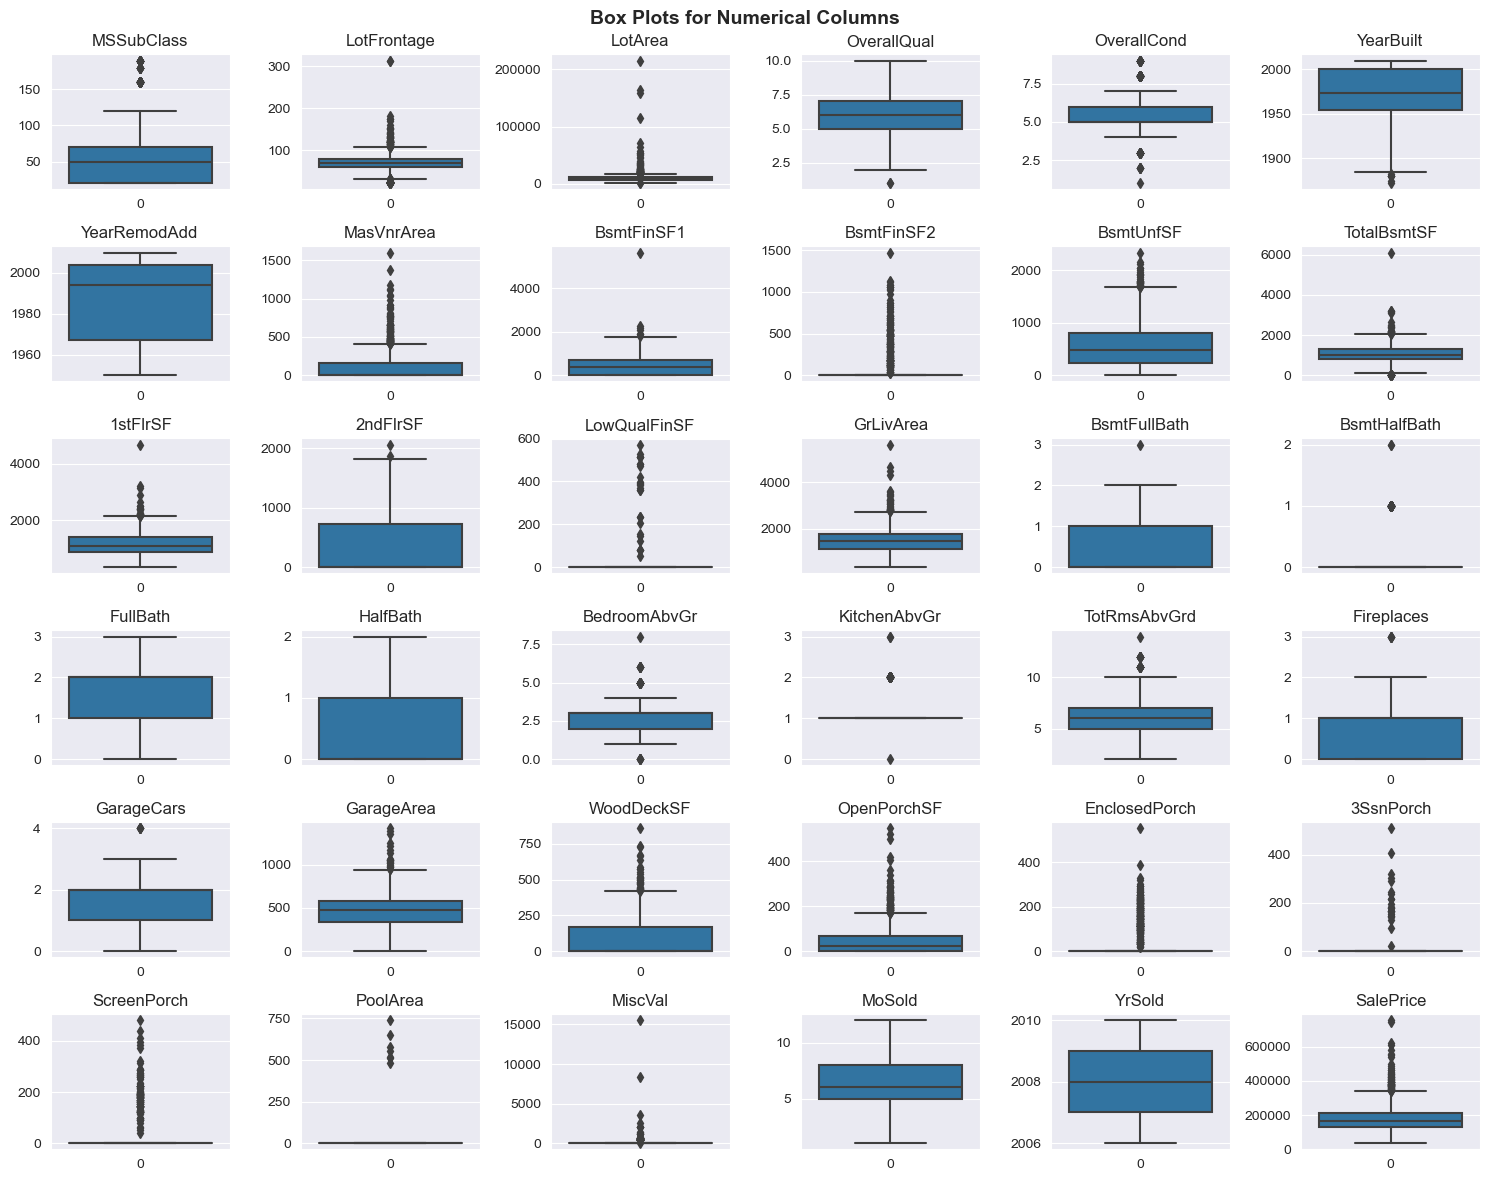

In [20]:
# List of numerical columns
numerical_columns = train_df.select_dtypes(exclude=['object']).columns

# Calculateing the number of rows and columns needed for the subplot grid
num_plots = len(numerical_columns)
num_rows = math.ceil(num_plots / 6)
num_cols = min(num_plots, 6)

# Creatingsubplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 2 * num_rows))

# Flattening the axes array if there is only one row
axes = axes.flatten() if num_rows > 1 else [axes]

# Looping through the numerical columns and create boxplots
for i, col in enumerate(numerical_columns):
    sns.boxplot(data=train_df[col],  ax=axes[i])
    axes[i].set_title(col)

# Removeing empty subplots if there are fewer than 6 columns
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adding a title to the main figure
fig.suptitle("Box Plots for Numerical Columns", fontsize=14, fontweight='bold')   
    
# Adjusting layout
plt.tight_layout()
plt.show()

From the above figure it can be inferred that there are outliers in the data. For the specific problem that we have, we will not remove outliers as the chances are that it might destroy some important data.

### Scatterplot of categorical vs "SalePrice"

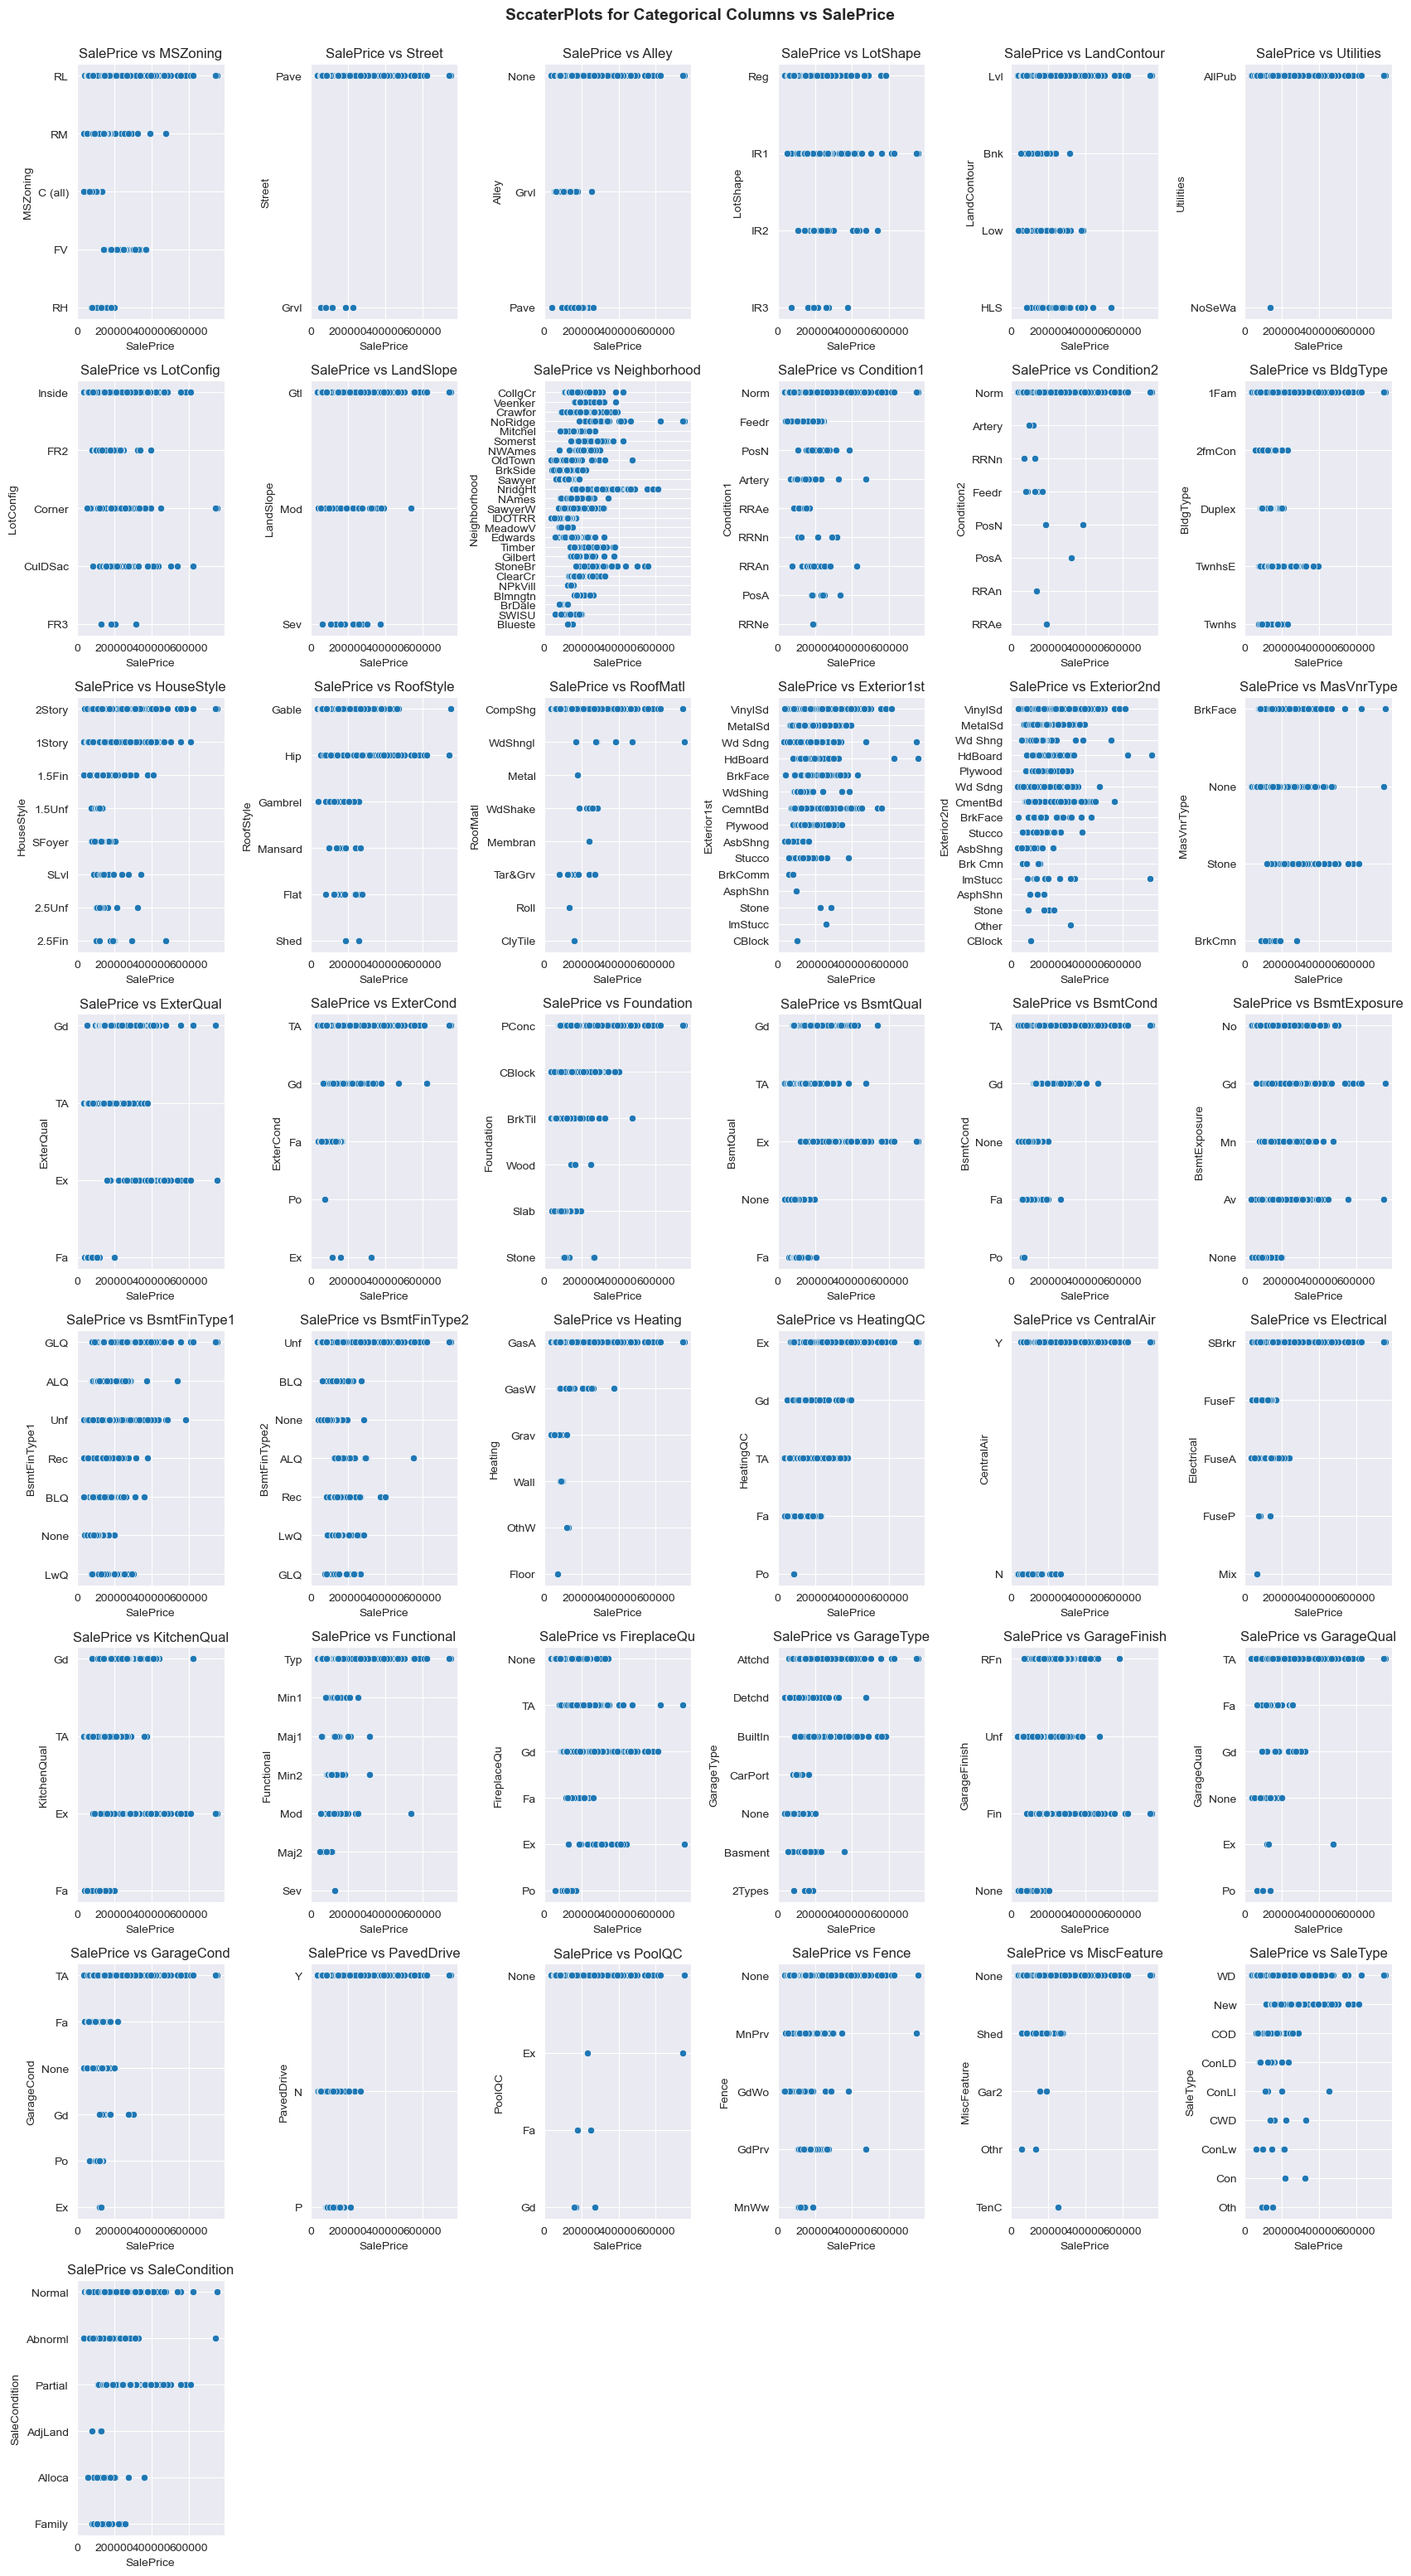

In [21]:
# List of categorical columns
object_columns = train_df.select_dtypes(include=['object']).columns

# Calculateing the number of rows and columns needed for the subplot grid
num_plots = len(object_columns)
num_rows = math.ceil(num_plots / 6)
num_cols = min(num_plots, 6)

# Createing subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(17, 4 * num_rows))

# Flattening the axes array if there is only one row
axes = axes.flatten() if num_rows > 1 else [axes]

# Looping through the categorical columns and create scatter plots
for i, col in enumerate(object_columns):
    sns.scatterplot(data=train_df, x='SalePrice', y=col, ax=axes[i])
    axes[i].set_title(f'SalePrice vs {col}')

# Removeing empty subplots if there are fewer than 6 columns
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adding a title to the main figure
fig.suptitle("SccaterPlots for Categorical Columns vs SalePrice", fontsize=14, fontweight='bold') 

# Adjusting layout
plt.tight_layout(rect=[0, 0.01, 1, 0.98])
plt.show()

From the above plots, it can be observed that there are some categorical features that the SalePrice is highly correlated. For example, the price of the houses is different for different neighborhood, quality, condition style and so on. 

### Heatmap of pearsons correlation between the features

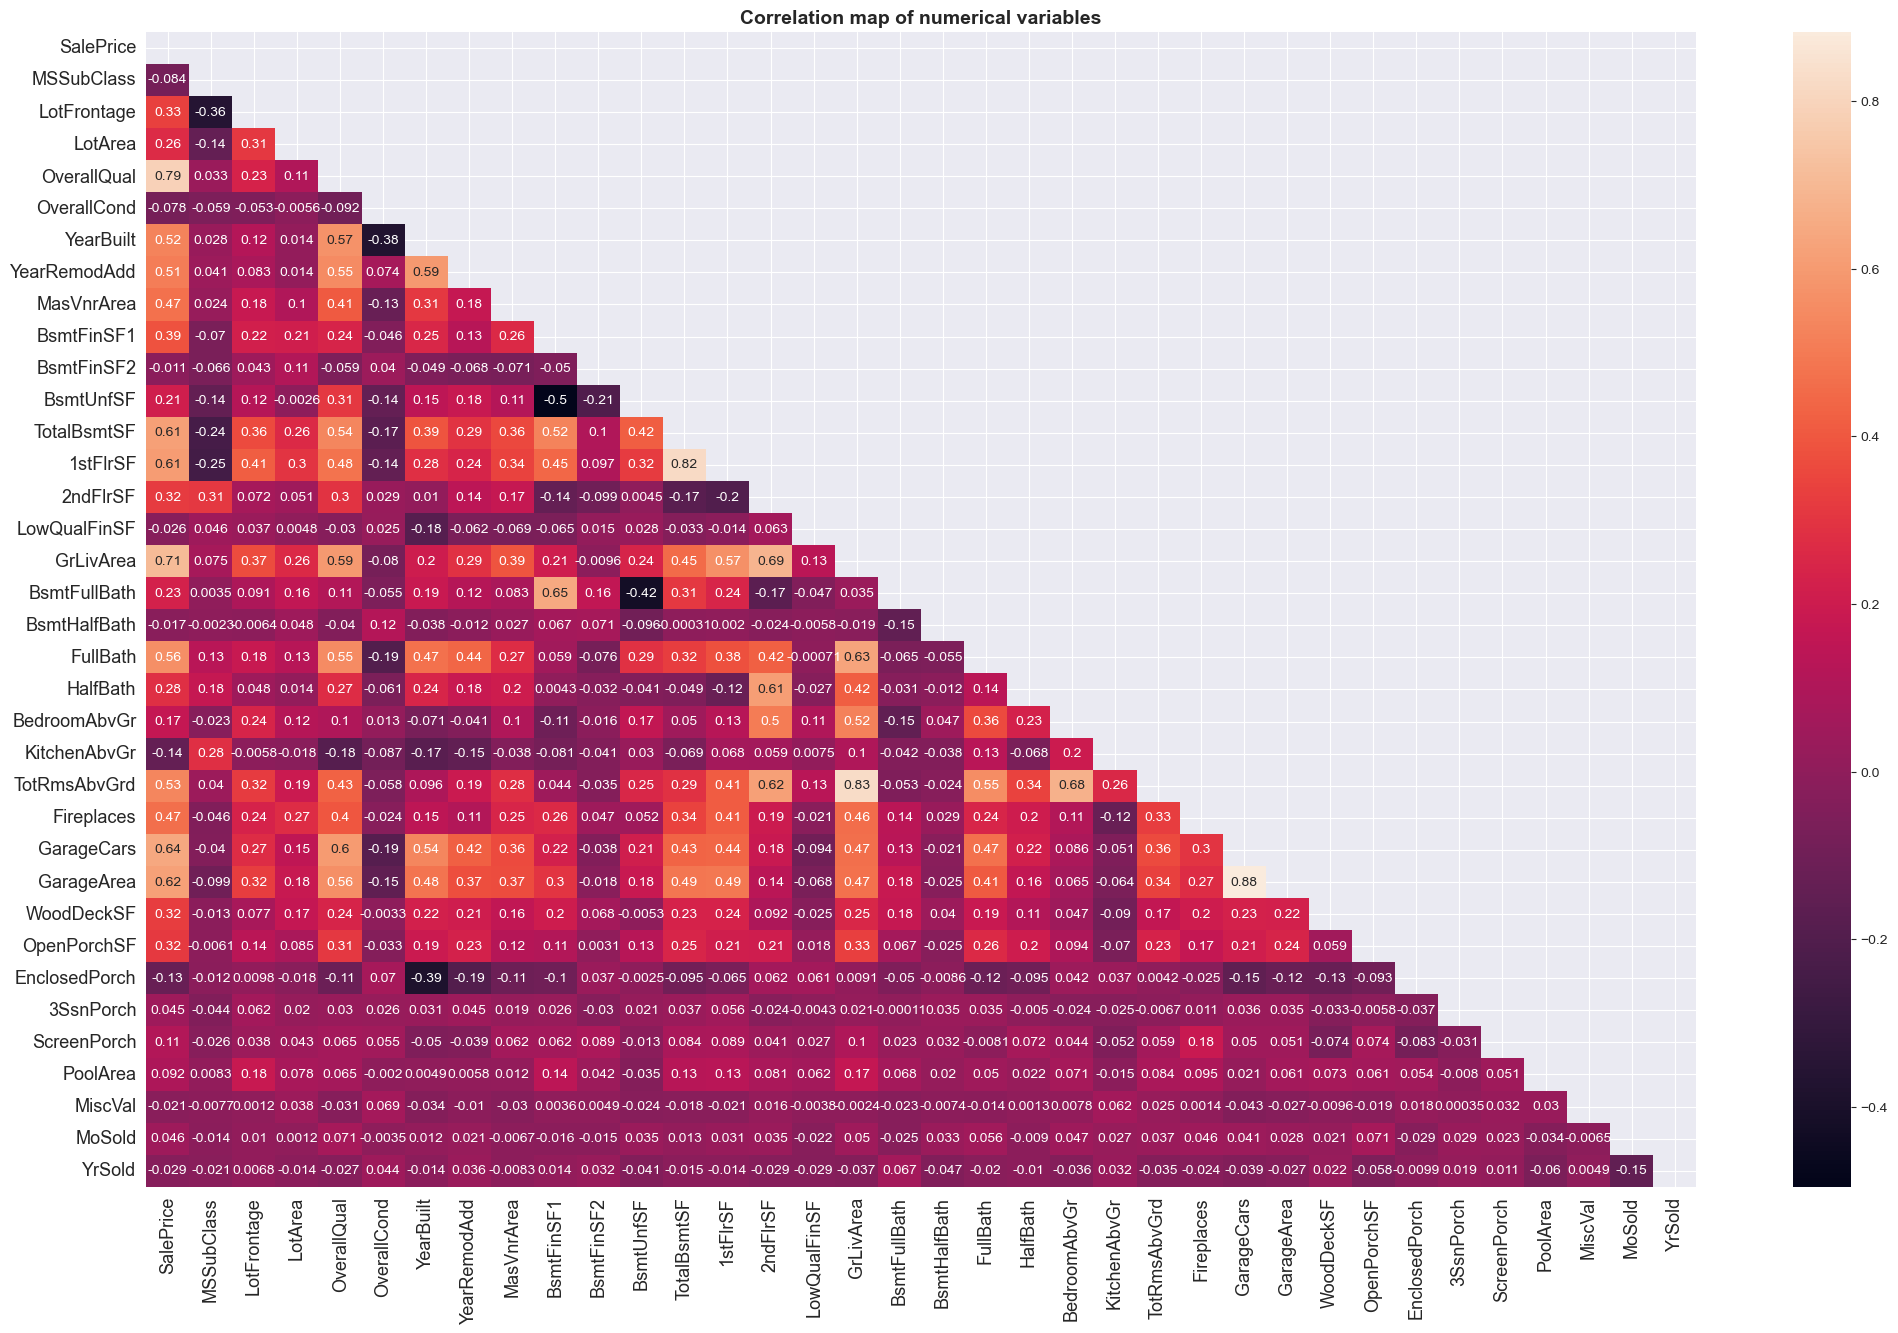

In [22]:
# Plotting the heatmap of correlations between features

fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(data=train_df[['SalePrice','MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold']].corr(), annot=True, mask = np.triu(np.ones_like(train_df[['SalePrice','MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold']].corr(), dtype=bool)))

plt.title('Correlation map of numerical variables', fontsize=14, fontweight = 'bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

### Data preprocessing

In [48]:
# Defineing X and Y

X = train_df.drop('SalePrice', axis = 1)
Y = train_df['SalePrice']

In [49]:
X.shape,  Y.shape

((1460, 78), (1460,))

In [50]:
# Defineing categorical and numerical columns from X (Features)

cat_columns = X.select_dtypes(include=['object']).columns
num_columns = X.select_dtypes(exclude=['object']).columns

In [51]:
### In the below codes, we will preprocess the data.
# We will get numerical columns and scale them using StandardScaler
# -------
# We will get categorical columns and encode them using OneHotEncoder


# Step 1: Defineing a pipeline for categorical columns
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False))
])

# Step 2: Defineing a pipeline for numerical columns
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Step 3: Combining the two pipelines using ColumnTransformer
processor = ColumnTransformer([
    ('categorical', categorical_pipeline, cat_columns),  # Apply categorical pipeline to categorical columns
    ('numerical', numerical_pipeline, num_columns)       # Apply numerical pipeline to numerical columns
], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

# The 'remainder' parameter ensures that any columns not specified in the transformers will be passed through without any processing.
# The 'verbose_feature_names_out' parameter controls whether to include feature names in the output.

# Step 4: Applying the transformations to the training dataset
df_train_processed = processor.fit_transform(X)

# Step 5: Applying the same transformations to the test dataset
df_test_processed = processor.transform(test_df)

### Feature Selection using RFE

In [52]:
# Using train_test_split to split data into training and testing parts

X_train, X_test, Y_train, Y_test = train_test_split(df_train_processed, Y, test_size=0.2, random_state=42)

X_train.shape, Y_train.shape , X_test.shape, Y_test.shape

((1168, 301), (1168,), (292, 301), (292,))

In [54]:
%%time  

# %%time Measures the execution time of the following code block

# Step 1: Create a Recursive Feature Elimination (RFE) with Cross-Validation (RFECV) pipeline

feature_selection_pipeline = RFECV(estimator=XGBRegressor(), cv=5)

# - The estimator is set to XGBRegressor, which is an XGBoost model used for feature selection.
# - RFECV performs recursive feature elimination with cross-validation to find the optimal set of features.

# Step 2: Fit the feature selection pipeline to the training data

feature_selection_pipeline.fit(X_train, Y_train)

# - X_train: The feature matrix of the training data.
# - Y_train: The target variable of the training data.
# - The pipeline will train the XGBRegressor model using recursive feature elimination and cross-validation.

# Note: The resulting feature selection pipeline now contains information about the selected features.

CPU times: total: 32min 46s
Wall time: 4min 34s


RFECV(cv=5,
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, device=None,
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, gamma=None, grow_policy=None,
                             importance_type=None, interaction_constraints=None,
                             learning_rate=None, max_bin=None,
                             max_cat_threshold=None, max_cat_to_onehot=None,
                             max_delta_step=None, max_depth=None,
                             max_leaves=None, min_child_weight=None,
                             missing=nan, monotone_constraints=None,
                             multi_strategy=None, n_estimators=None,
                             n_jobs=None, num_parallel_tree=None,
                             random_state=None, ...))

In [55]:
# All Features name from the train dataset
feature_names = X_train.columns

# Getting only the selected features using RFE
selected_feature_names = feature_names[feature_selection_pipeline.support_]
selected_feature_names

Index(['MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'Street_Grvl', 'Alley_Grvl', 'Alley_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3',
       ...
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object', length=196)

## Creating the Xgboost Model

In [56]:
# Defining independed and depended variables with the features that were selected

X_for_training = df_train_processed[selected_feature_names] 

Y_for_training = train_df['SalePrice']

# Using train_test_split to split data into training and testing parts
X_train, X_test, Y_train, Y_test = train_test_split(X_for_training, Y_for_training, test_size=0.3, random_state=0)

In [57]:
X_train.shape , X_test.shape , Y_train.shape , Y_test.shape

((1022, 196), (438, 196), (1022,), (438,))

### Using Grid search to find the best parameters

In [58]:
%%time 

# Defineing the parameter grid to use for grid search

param_grid = {
    'n_estimators': [3000, 5000],
    'max_depth': [4],
    'learning_rate': [0.03],
    'colsample_bytree': [0.4],
    'subsample': [0.5],
    'min_child_weight': [1],
}

# Createing an XGBRegressor instance
regressor = xgb.XGBRegressor(booster='gbtree', early_stopping_rounds=500, eval_metric='rmsle')

# Creating GridSearchCV instance
grid_search = GridSearchCV(regressor, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fitting the model to the data
grid_search.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=500)

# Printing the best parameters and corresponding performance
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[0]	validation_0-rmsle:0.40199	validation_1-rmsle:0.39213
[500]	validation_0-rmsle:0.09349	validation_1-rmsle:0.13141
[1000]	validation_0-rmsle:0.08558	validation_1-rmsle:0.13165
[1141]	validation_0-rmsle:0.08479	validation_1-rmsle:0.13184
[CV] END colsample_bytree=0.4, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=3000, subsample=0.5; total time=   3.9s
[0]	validation_0-rmsle:0.39938	validation_1-rmsle:0.39013
[500]	validation_0-rmsle:0.08732	validation_1-rmsle:0.11897
[1000]	validation_0-rmsle:0.07854	validation_1-rmsle:0.11950
[1005]	validation_0-rmsle:0.07852	validation_1-rmsle:0.11947
[CV] END colsample_bytree=0.4, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=3000, subsample=0.5; total time=   3.5s
[0]	validation_0-rmsle:0.40793	validation_1-rmsle:0.39772
[500]	validation_0-rmsle:0.08128	validation_1-rmsle:0.11857
[1000]	validation_0-rmsle:0.06914	validation_1-rmsle:0.11850
[1069]	v

### Training the model with the best parameters

In [59]:
# Fitting the xgboost model with best parameters from grid searchcv

regressor = xgb.XGBRegressor(booster = 'gbtree',
                             colsample_bytree = 0.4,
                             n_estimators = 3000, 
                             min_child_weight = 1,
                             subsample = 0.5,
                             early_stopping_rounds=500,
                             objective = 'reg:squarederror',
                             max_depth=4,
                             eval_metric='rmsle',
                             learning_rate = 0.03)

# Fitting the xgboost model
regressor.fit(X_train, Y_train,
       eval_set = [(X_train, Y_train), (X_test, Y_test)],
       verbose = 500)

[0]	validation_0-rmsle:0.40213	validation_1-rmsle:0.39180
[500]	validation_0-rmsle:0.06559	validation_1-rmsle:0.11193
[1000]	validation_0-rmsle:0.03893	validation_1-rmsle:0.11229
[1038]	validation_0-rmsle:0.03743	validation_1-rmsle:0.11234


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=500,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
predictions_test = regressor.predict(X_test)

#from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt(mean_squared_log_error(Y_test, predictions_test))
print("The score is %.5f" % RMSLE)

The score is 0.11159


## Predicting the test_df data

In [61]:
# Predicting the house price of the test_df

y_predict = regressor.predict(df_test_processed[selected_feature_names])

In [62]:
# Reading the test df (To get the ID Column)
test_df = pd.read_csv('../data/test.csv')

In [ ]:
# Creating a df for the predicted prices
predictions_df = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': y_predict})

# Storing the created df to a csv file
predictions_df.to_csv('../stored results/predicted_test_df_prices.csv', index=False)
predictions_df.head(10)